In [216]:
import json
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap


from tqdm import tqdm_notebook

import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, roc_curve, auc


# Introduction

Fraud detection

# Data Preparation

## Json formatting

The first step of is to format the json data into structured, easier to manipulate, data. The json read is a list of multiple dictionaries, each one contains data about a specific customer, his fraud status (true or false) and his orders.\

Each customer can have multiple orders, and each order can either be fulfilled, pending or failed.

In [217]:
lst = []
for f in open("./user_profiles.json", "r"):
    lst += [json.loads(f)] # Read the json file and store its content into a list: lst

all_info_data = []
for customer in tqdm_notebook(lst):
    fraud = customer["fraudulent"] # Get customer fraud status
    customer_data = customer["customer"] # Get customer data
    orders_data = customer["orders"] # Gist list of orders

    if len(orders_data) > 0: # If customer has orders
        data_orders = pd.DataFrame.from_records(orders_data) # Store orders in a customer sub-data frame
        for custom_col in customer_data.keys():
            data_orders[custom_col] = customer_data[custom_col] # Add customer info to the orders sub-dataframe
    else: # If customer has no orders
        data_orders = pd.DataFrame.from_records([customer_data]) # only customer data is stored, orders columns are empty
    data_orders["fraudulent"] = fraud # Fraud status is stored in the column
    all_info_data += [data_orders] # add Customer sub-dataframe to the list of all customers

    # pass
all_info_data = pd.concat(all_info_data).reset_index(drop = True) # Concatenate all sub-dataframes into a single dataframe

C:\Users\Hamza.LAHKIM\AppData\Local\Temp\ipykernel_12136\1910323560.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for customer in tqdm_notebook(lst):


  0%|          | 0/168 [00:00<?, ?it/s]

After structuring the data, the user profiles are stored in an excel file with the same name: user_profiles.xlsx

In [218]:
# all_info_data.to_excel("./user_profiles.xlsx", index = False)

## Extract features

The dataset contains multiple customers. For each customer, there are multiple orders. Each (customer, order) have unique characteristics which could be used to extract useful information.

Since the customer is the one labelled fraudulent/or not and not the order, we will have to aggregate the order characteristics into summarized features, depicting a characteristic of the customer.

The new features will either be extracted from the feature directly or combined with another feature.

* **totalPendingAmount**: total amount of pending orders for the customer
* **totalFailedAmount**: total amount of failed orders for the customer
* **totalFulfilledAmount**: total amount of fulfilled orders for the customer
* **percentFailed**: percentage of failed orders
* **percentOrderAdressIsCustomerAdress**: Percentage of times the order adress is the customer adress
* **numberOrders**: Number of orders by the customer
* **emailProvider**: The name of the email provider (gmail, yahoo, malone...), the intuition is that non-famous email providers may be related to some fraudulent activities with fraud customers using fake emails
* **averageAmountOrder**: average amount spent on the orders
* **maxAmountOrder**: maximum amount spent on the orders
* **minAmountOrder**: minimum amount spent on the orders

**Define ID to use**

Customer email and customer phone provide unique values identifying a customer in the dataset

In [219]:
customer_data = pd.DataFrame.from_records([l["customer"] for l in lst])
customer_data["customerEmail"].duplicated().sum() # Check if customerEmail is duplicated

7

In [220]:
# Check if customerEmail, CustomerPhone provide a unique combined ID for customer
all_info_data[['customerEmail', 'customerPhone']].drop_duplicates().shape[0], len(lst) 

(168, 168)

In [221]:
all_info_data.head()

,orderId,orderAmount,orderState,orderShippingAddress,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,fraudulent
0,vjbdvd,18.0,pending,"5493 Jones Islands\nBrownside, CA 51896",josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",False
1,yp6x27,26.0,fulfilled,"5493 Jones Islands\nBrownside, CA 51896",josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",False
2,nlghpa,45.0,fulfilled,"898 Henry Ports\nNew Keithview, CA 95893-2497",evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,True
3,uw0eeb,23.0,fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,True
4,bn44oh,43.0,fulfilled,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,True


**totalFailedAmount, totalFulfilledAmount & totalPendingAmount**

In [222]:
# Compute total amount of orders that failed, are fulfilled or pending for each customer
orders_amount_df = all_info_data.groupby(['customerEmail', 'customerPhone', "orderState"]).agg({"orderAmount": sum}).unstack("orderState").reset_index()
orders_amount_df.columns = ["customerEmail", "customerPhone", "totalFailedAmount", "totalFulfilledAmount", "totalPendingAmount"]
orders_amount_df = orders_amount_df.fillna(0)

**percentFailed & percentFulfilled**

In [223]:
# Compute percentage of failed and fulfilled orders per customer
percentOrderState = all_info_data[['customerEmail', 'customerPhone', "orderState", "orderId"]].groupby(['customerEmail', 'customerPhone', "orderState"]).agg({"count"}).unstack("orderState").reset_index()
percentOrderState.columns = ["customerEmail", "customerPhone", "failedNumber", "fulfilledNumber", "pendingNumber"]
percentOrderState = percentOrderState.fillna(0)
percentOrderState["percentFailed"] = 100 * percentOrderState["failedNumber"] / (percentOrderState["failedNumber"] + percentOrderState["fulfilledNumber"] + percentOrderState["pendingNumber"])
percentOrderState["percentFulfilled"] = 100 * percentOrderState["fulfilledNumber"] / (percentOrderState["failedNumber"] + percentOrderState["fulfilledNumber"] + percentOrderState["pendingNumber"])
percentOrderState = percentOrderState.drop(columns = ["failedNumber", "fulfilledNumber", "pendingNumber"])

**percentOrderAdressIsCustomerAdress & numberOrders**

In [224]:
# Percent of orders with billing adress equal to order address
# Get Number of orders

all_info_data["OrderAdressIsCustomerAdress"] = (all_info_data["customerBillingAddress"] == all_info_data["orderShippingAddress"])

orderAdress = all_info_data[['customerEmail', 'customerPhone', "orderId", "OrderAdressIsCustomerAdress"]].groupby(['customerEmail', 'customerPhone']).agg({"OrderAdressIsCustomerAdress": sum, "orderId": "count"}).reset_index()
orderAdress.columns = ["customerEmail", "customerPhone", "numberOrderAdressIsCustomerAdress", "numberOrders"]
orderAdress = orderAdress.fillna(0)
orderAdress["orderAdress"] = 100 * orderAdress["numberOrderAdressIsCustomerAdress"] / orderAdress["numberOrders"]
orderAdress = orderAdress.fillna(0).drop(columns = ["numberOrderAdressIsCustomerAdress"])


**emailProvider**

In [225]:
# Extract email provider from email
all_info_data["emailProvider"] = [re.split("@|\.", all_info_data["customerEmail"][i])[-2] if "." in all_info_data["customerEmail"][i] else re.split("@", all_info_data["customerEmail"][i])[-1] for i in all_info_data.index]
emailProvider_df = all_info_data[['customerEmail', 'customerPhone', 'emailProvider']].drop_duplicates()

**averageAmountOrder, maxAmountOrder & minAmountOrder**

In [226]:
# Get average, max and min amount spent by order
amountOrders = all_info_data[['customerEmail', 'customerPhone', "orderAmount"]].groupby(['customerEmail', 'customerPhone']).agg({"orderAmount": ['mean', 'min', 'max']}).reset_index()
amountOrders.columns = ["customerEmail", "customerPhone", "averageAmountOrder", "minAmountOrder", "maxAmountOrder"]
amountOrders = amountOrders.fillna(0)


### Combined data

In [227]:
# Combine all features extracted into a single dataframe
all_data = pd.merge(emailProvider_df, percentOrderState, on = ['customerEmail', 'customerPhone'], how = "left")
all_data = pd.merge(all_data, orderAdress, on = ['customerEmail', 'customerPhone'], how = "left")
all_data = pd.merge(all_data, orders_amount_df, on = ['customerEmail', 'customerPhone'], how = "left")
all_data = pd.merge(all_data, amountOrders, on = ['customerEmail', 'customerPhone'], how = "left")
output = all_info_data[['customerEmail', 'customerPhone', "fraudulent"]].drop_duplicates()
all_data = pd.merge(all_data, output, on = ['customerEmail', 'customerPhone'], how = "left")
# Compute total amount spent on orders, regardless of their status
all_data["totalAmountOrders"] = all_data["totalFailedAmount"] + all_data["totalFulfilledAmount"] + all_data["totalPendingAmount"]
all_data = all_data.fillna(0)

# EDA

In [228]:
# Set visualization color palette for seaborn visualization
colors = ["#00C9C4", "#BF86BF", "#895389", "#B6A6B5"]
sns.set_palette(sns.color_palette(colors)) # Inspired by INWI main color

The first step is to visualize the email providers extracted from customer Emails. Visualizing the 8 most frequent email providers shows fairly standard results. "gmail" is the most frequent provider, followed by "yahoo" and then "hotmail". Other non-famous providers are also present but in much smaller occurances. Hence, all of them will be aggregated into one category named other.

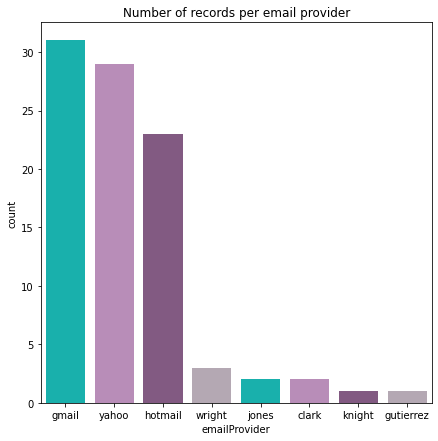

In [229]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
N = 8
sns.countplot(x=all_data["emailProvider"], order=pd.value_counts(all_data["emailProvider"]).iloc[:N].index, ax = ax, palette=sns.color_palette(colors))
ax.set_title("Number of records per email provider")
plt.show()

Since the variable is now categorical, with 4 possibilities, it is transformed into a numerical one using one-hot encoding. Therefore, we get 4 binary variables.

In [230]:
all_data["emailProvider"] = [all_data["emailProvider"][i] if all_data["emailProvider"][i] in ["gmail", "yahoo", "hotmail"] else "other" for i in all_data.index]
all_data = pd.concat([all_data, pd.get_dummies(all_data["emailProvider"])], axis = 1)

To evaluate the correlation between two categorical variables, a contingency matrix is used. The most frequent category is now "other", which combines all non-famous providers. The highest percentage of fraudulent customers use "gmail": 15/31, followed by the "other"s with 34/51.\
This variable does not seem to be strongly correlated with the output variable

C:\Users\Hamza.LAHKIM\AppData\Local\Temp\ipykernel_12136\1871149665.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  contingency_matrix = contingency_matrix.groupby(["fraudulent", "emailProvider"]).agg("count").reset_index().pivot("fraudulent", "emailProvider")


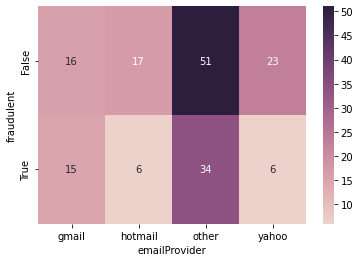

In [231]:
contingency_matrix = all_data[["fraudulent", "emailProvider"]]
contingency_matrix= contingency_matrix.reset_index()
contingency_matrix = contingency_matrix.groupby(["fraudulent", "emailProvider"]).agg("count").reset_index().pivot("fraudulent", "emailProvider")
contingency_matrix.columns = contingency_matrix.columns.get_level_values(1)
sns.heatmap(contingency_matrix, annot=True, cmap = sns.cubehelix_palette(as_cmap=True))
plt.show()
# contingency_matrix

A correlation matrix is used to evaluate the bivariate correlations between numerical variables in the dataset.\
Although the output is binary, we have included it as a numerical (0, 1) variable.\
The highly correlated (>0.9) variables in the data set are:
* percentFailed and totalAmountFailed
* numberOrders and totalFulfilledAmount
* numberOrders and totalAmountOrders
* totalFulfilledAmount and totalAmountOrders

To avoid having highly correlated variables, the variables numberOrders, totalAmountOrders and percentFailed will be removed from the dataset.



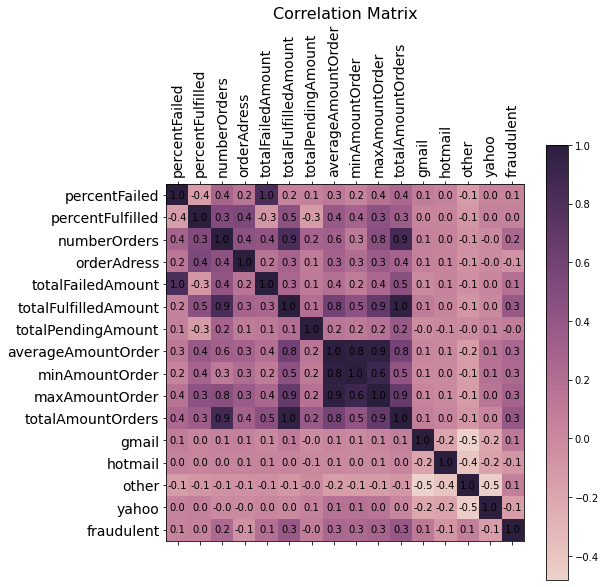

In [232]:
df_corr = all_data.drop(columns = ['customerEmail', 'customerPhone', "emailProvider"])
df_corr = df_corr[list(df_corr.drop(columns = ["fraudulent"]).columns) + ["fraudulent"]] # Put output as the last column in the dataset
df_corr["fraudulent"] = df_corr["fraudulent"]*1
fig, ax = plt.subplots(figsize = (8, 8))
# cmap = ListedColormap(colors)
cax = ax.matshow(df_corr.corr(), cmap=sns.cubehelix_palette(as_cmap=True))
fig.colorbar(cax)
for (i, j), z in np.ndenumerate(df_corr.corr(method = "spearman")):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.xticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()


The total amount for fraudulent customers reaches higher values (in average and in maximum) compared to non fraudulent ones. Hence, the amount spent on the orders is a great indicator of fraudulent activities. This is also very intuitive.

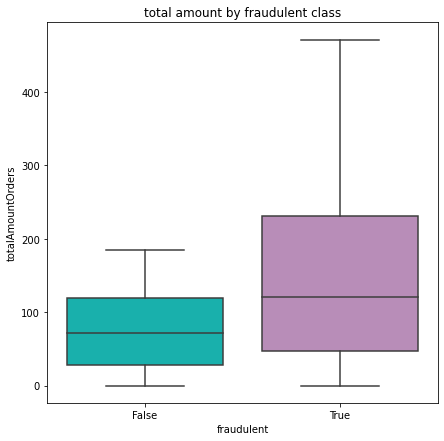

In [233]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
sns.boxplot(data = all_data, x = "fraudulent", y = "totalAmountOrders", showfliers = False, ax = ax)
ax.set_title("total amount by fraudulent class")
plt.show()

The separation of maximum, minimum and average values shows the same conclusion. In terms of the three measures, the fraudulent customers have the higher values compared to the non-fraudulent ones.

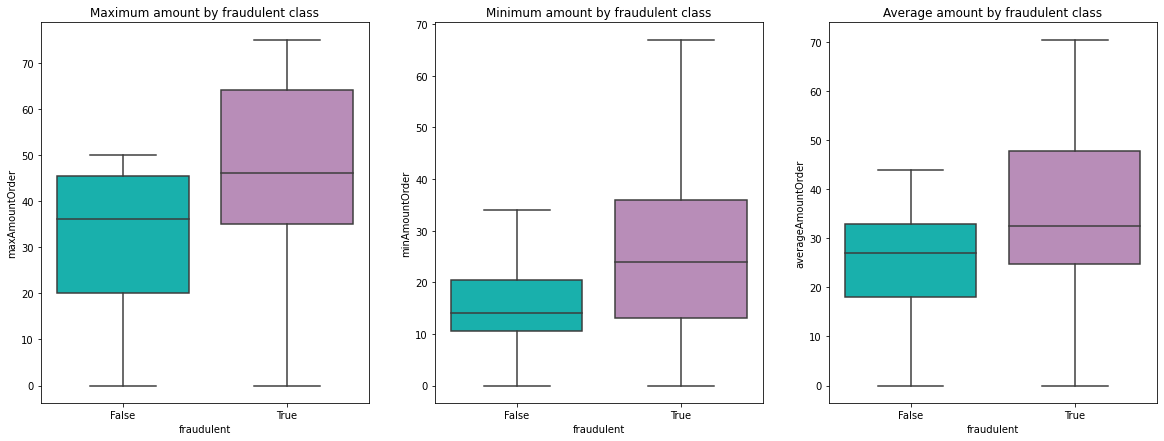

In [234]:
fig, axs = plt.subplots(1, 3, figsize = (20, 7))
sns.boxplot(data = all_data, x = "fraudulent", y = "maxAmountOrder", showfliers = False, ax = axs[0])
axs[0].set_title("Maximum amount by fraudulent class")
sns.boxplot(data = all_data, x = "fraudulent", y = "minAmountOrder", showfliers = False, ax = axs[1])
axs[1].set_title("Minimum amount by fraudulent class")
sns.boxplot(data = all_data, x = "fraudulent", y = "averageAmountOrder", showfliers = False, ax = axs[2])
axs[2].set_title("Average amount by fraudulent class")
plt.show()

The separation of the amount by order status also shows higher amounts spent on the orders for fraudulent customers. Moreover, we can see that the number of failing orders for fraudulent customers is higher to the others.

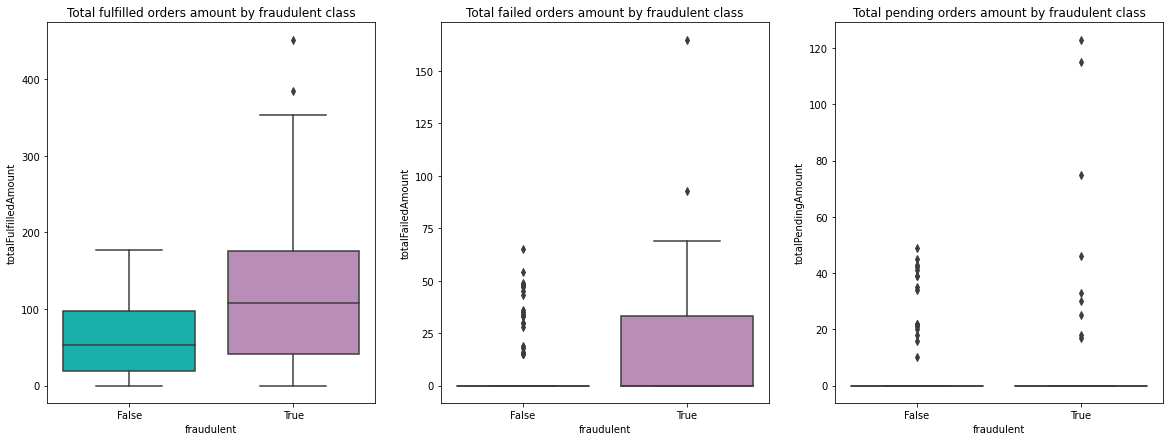

In [235]:
fig, axs = plt.subplots(1, 3, figsize = (20, 7))
sns.boxplot(data = all_data, x = "fraudulent", y = "totalFulfilledAmount", showfliers = True, ax = axs[0])
axs[0].set_title("Total fulfilled orders amount by fraudulent class")
sns.boxplot(data = all_data, x = "fraudulent", y = "totalFailedAmount", showfliers = True, ax = axs[1])
axs[1].set_title("Total failed orders amount by fraudulent class")
sns.boxplot(data = all_data, x = "fraudulent", y = "totalPendingAmount", showfliers = True, ax = axs[2])
axs[2].set_title("Total pending orders amount by fraudulent class")
plt.show()

For non fraudulent customers, failing an order is mainly an outlier, however, for fraudulent ones, failing an order happens more frequently, although the percentage of failure may reach closer to 50% for both. Fulfilled orders' percentage also have similar values for the two possible cases.

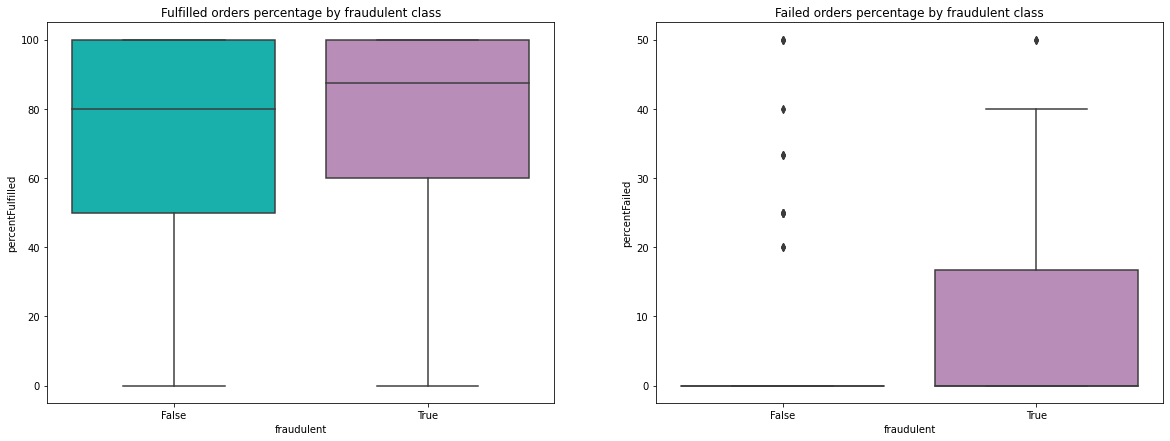

In [236]:
fig, axs = plt.subplots(1, 2, figsize = (20, 7))
sns.boxplot(data = all_data, x = "fraudulent", y = "percentFulfilled", showfliers = True, ax = axs[0])
axs[0].set_title("Fulfilled orders percentage by fraudulent class")
sns.boxplot(data = all_data, x = "fraudulent", y = "percentFailed", showfliers = True, ax = axs[1])
axs[1].set_title("Failed orders percentage by fraudulent class")
plt.show()

The number of orders for fraudulent customers reach higher values (in average and in maximum) compared to the others. The percentage of orders with billing adress different from order adress is however not very significant.

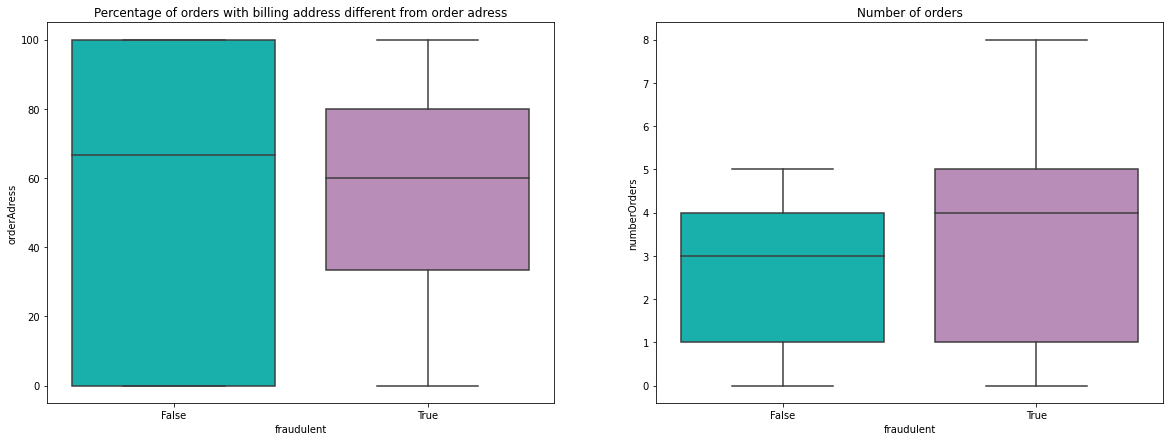

In [237]:
fig, axs = plt.subplots(1, 2, figsize = (20, 7))
sns.boxplot(data = all_data, x = "fraudulent", y = "orderAdress", showfliers = True, ax = axs[0])
axs[0].set_title("Percentage of orders with billing address different from order adress")
sns.boxplot(data = all_data, x = "fraudulent", y = "numberOrders", showfliers = True, ax = axs[1])
axs[1].set_title("Number of orders")
plt.show()

Based on the chart below, the output is unbalanced. We have much more non-fraudulent customers than fraudulent ones.\
During the modelling phase, attention needs to be paid and two measures should be taken:
* **Use recall or AUC instead of accuracy to evaluate performance**\
Recall measures the percentage of fraudulent customers detected by the model, hence it is not biased by the number of non-fraudulent ones.\
Since the data is not balanced, the output would much more likely be biased towards non-fraudulent observations. Hence, a custom threshold should be used for the probability of a customer being fraudulent.\
The optimal threshold is detected using the ROC curve, and the AUC measure helps determine if the model is good enough to separate between the two output possibilities.

* **Perform some balancing measures on the training set**\
There are multiple balancing techniques which could be used to reduce the effect of the unbalance. In this analysis, SMOTE will be used.

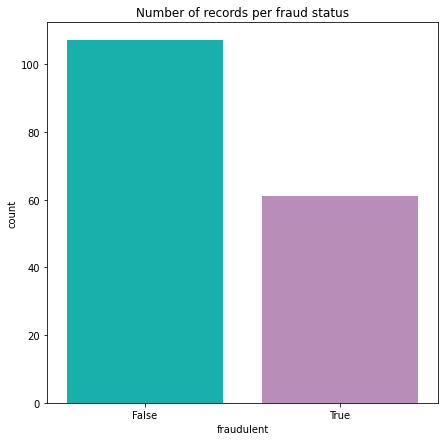

In [238]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
sns.countplot(x=all_data["fraudulent"], ax = ax)
ax.set_title("Number of records per fraud status")
plt.show()

**PCA analysis**

PCA is a dimension reduction technique to synthesize/project the information in the inputs data to a lower dimension, hence providing an insight into the potential of the inputs to separate our output classes (fraud or not).\

Performing PCA analysis on our dataset and visualizing the result in the chart below shows that along principal dimension 1, we have a good separation of fraudulent and non-fraudulent activities. While non-fraudulent customers are centered between -100 and +100, fraudulent customers reach over +100. "principal component 2" does not provide the same separation capabilities however.\

Nevertheless, there are many fraudulent customers which the data is not able to distinguish and that are in the (-100, +100) interval of principal component 1, while not being separated by components 2 or 3. There customers will be the source of confusion during the modelling phase and will reduce the recall measure computed.

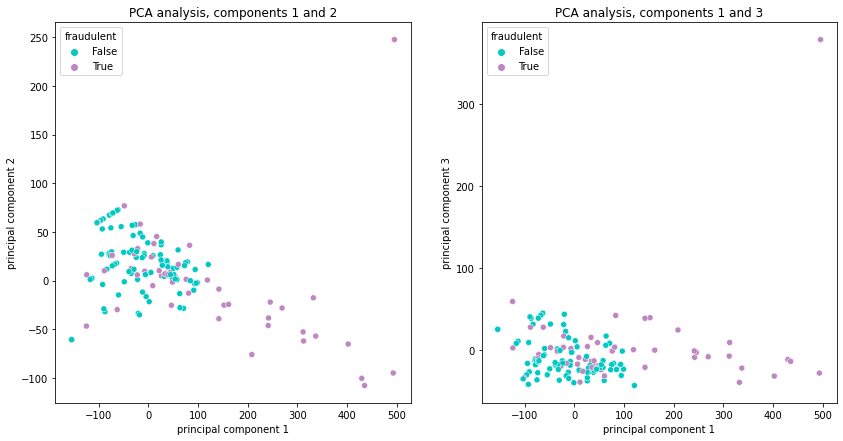

In [239]:
X, y = all_data.drop(columns = ['customerEmail', 'customerPhone', "fraudulent", "emailProvider", "gmail", "hotmail", "yahoo"]), all_data["fraudulent"]

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
finalDf = pd.concat([principalDf, y], axis = 1)


fig, axs = plt.subplots(1, 2, figsize = (14,7))
sns.scatterplot(data = finalDf, x = "principal component 1", y = "principal component 2", hue = "fraudulent", palette=sns.color_palette(colors[0:2]), ax = axs[0])
axs[0].set_title("PCA analysis, components 1 and 2")
sns.scatterplot(data = finalDf, x = "principal component 1", y = "principal component 3", hue = "fraudulent", palette=sns.color_palette(colors[0:2]), ax = axs[1])
axs[1].set_title("PCA analysis, components 1 and 3")
plt.show()


Each component is a linear combination of the original inputs, hence showing the correlation matrix below, we can see which features helped separate between fraudulent and non-fraudulent customers.\
The correlation matrix shows that the principal component 1, which helps detect fraudulent customers is correlated with the following variables, making them the parameters with the highest impact:
* Number of orders
* Total fulfilled amount
* Average amount by order
* total amount of orders

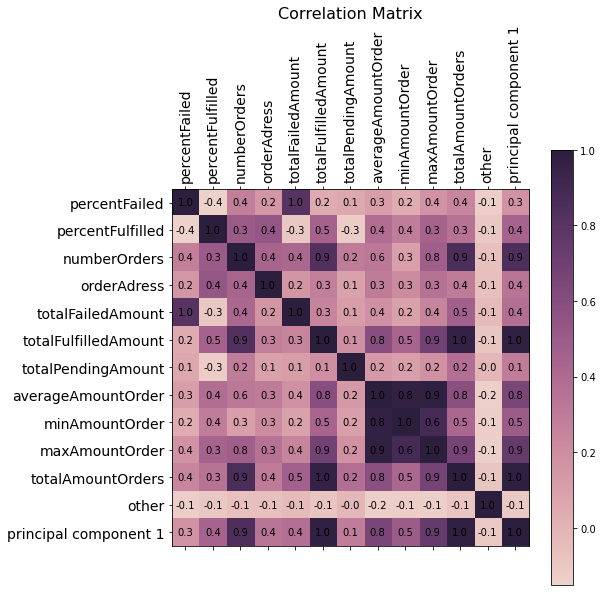

In [240]:
pca_data = pd.concat([X, finalDf["principal component 1"]], axis = 1)

df_corr = pca_data
fig, ax = plt.subplots(figsize = (8, 8))
# cmap = ListedColormap(colors)
cax = ax.matshow(df_corr.corr(), cmap=sns.cubehelix_palette(as_cmap=True))
fig.colorbar(cax)
for (i, j), z in np.ndenumerate(df_corr.corr(method = "spearman")):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.xticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

# Overview of the dataset

The dataset is very rich in terms of the 

# Modelling

In [241]:
X, y = all_data.drop(columns = ['customerEmail', 'customerPhone', "numberOrders", "totalAmountOrders", "percentFailed", "fraudulent", "emailProvider", "gmail", "hotmail", "yahoo"]), all_data["fraudulent"]

In [242]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

models = {
    "lm": {"model": LogisticRegression(random_state=0)},
    "gb": {"model": GradientBoostingClassifier(random_state=0)},
    "rf": {"model": RandomForestClassifier(random_state=0)},
    "svc": {"model": SVC(random_state=0)},
    "xgb": {"model": XGBClassifier(random_state=0, eval_metric="logloss")}
}

# y = np.log(y + 100)

for m in tqdm_notebook(models.keys()):
    scores = cross_val_score(models[m]["model"], X, y, cv=5, scoring = "recall")
    # models[m]["scores"] = scores
    models[m]["average"] = np.mean(scores)
# print(models)

C:\Users\Hamza.LAHKIM\AppData\Local\Temp\ipykernel_12136\2932144678.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm_notebook(models.keys()):


  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\Hamza.LAHKIM\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Hamza.LAHKIM\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

In [243]:
print(models)


{'lm': {'model': LogisticRegression(random_state=0), 'average': 0.39358974358974363}, 'gb': {'model': GradientBoostingClassifier(random_state=0), 'average': 0.45897435897435895}, 'rf': {'model': RandomForestClassifier(random_state=0), 'average': 0.44230769230769224}, 'svc': {'model': SVC(random_state=0), 'average': 0.2948717948717949}, 'xgb': {'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='logloss', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=N

To avoid the longer time spent on grid seach cross validation, a manual parameter tuning is done on the random forest classifier. The 4-Fold cross validation on the tuned model using accuracy as the performance measure shows that there is not much of a difference between the 4 splits. Hence, the 75% train/25 test split provides a good representative sample to evaluate the model.\
The accuracy on the 25% test is equal to 81%. However, this measure is biased by the number of non-fraudulent customers.

In [244]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline


X_train, X_test, y_train, y_test = train_test_split(X, y * 1, test_size=0.25, random_state=0)
model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 30, min_samples_split=2, min_samples_leaf =1, max_depth=3, random_state=0))

scores = cross_val_score(model, X, y, cv=4)
print("5-Fold cross validation recall ", scores)


model.fit(X_train, y_train)
model.score(X_test, y_test)

5-Fold cross validation recall  [0.73809524 0.76190476 0.78571429 0.71428571]


0.8095238095238095

The auc score is equal to 78%. Given that a score of 50% means that the model has no predictive ability and 100% represents a perfect model, 78% is then a fairly good result.

auc 0.7859237536656891


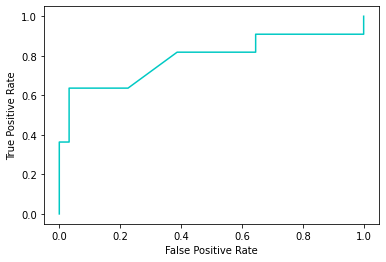

In [245]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score
predictions = model.predict_proba(X_test)[..., 1]

fpr, tpr, _ = roc_curve(y_test,  predictions)
print("auc", auc(fpr, tpr))

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The threshold to predict fraudulent customers is also calibrated to detect the maximum number frauds without false alarming about all of them. A recall of 81% is fairly good, also it gives a 42% chance of false alarms.

recall 0.8181818181818182
F1 score 0.5454545454545455


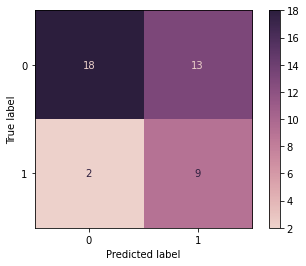

In [246]:
import matplotlib as mpl
predictions_prob = model.predict_proba(X_test)[..., 1]
predictions = (predictions_prob > 0.28)
print("recall", recall_score(y_test, predictions))
print("F1 score", f1_score(y_test, predictions))

cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap = sns.cubehelix_palette(as_cmap=True))
plt.show()

The random forest classifier computes a feature importance measure for each feature. A random forest model is a combination of decision trees using the bagging algorithm. In decision trees, each node is split based on a specific feature. Hence, the features that occur more frequently in the trained individual trees are important in making the final prediction.\

Therefore, the chart below shows the list most important features in decreasing order. The most important one is the average amount by order for each customer, followed by the maximum amount, then total amount of fulfilled orders and finally the minimum amount of the orders made by the customer. The remaining features are much less important in the final prediction.\

The results shown by the random forest feature importance are coherent with what was found during the PCA analysis.

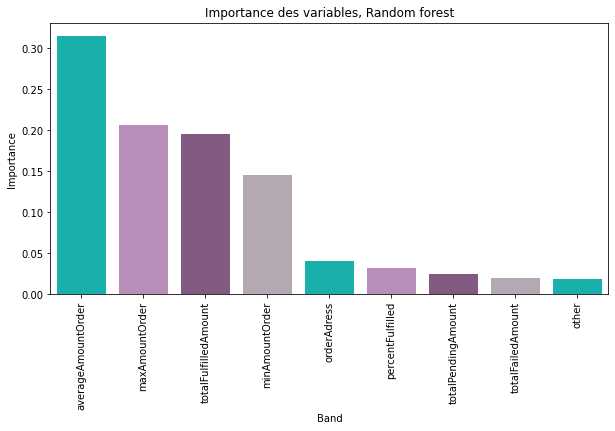

In [170]:
importance = model["randomforestclassifier"].feature_importances_
importance_df = pd.DataFrame()
importance_df["Band"] = X.columns
importance_df["Importance"] = importance
importance_df = importance_df.sort_values(by = "Importance", ascending = False)
importance_df = importance_df.reset_index(drop = True)

figure = plt.figure(figsize = (10, 5))
ax = sns.barplot(x="Band", y="Importance", data=importance_df.loc[:15], palette=sns.color_palette(colors))
# ax.set_yscale("log")
plt.xticks(rotation = 90)
plt.xlabel("Band")
plt.ylabel("Importance")
plt.title("Importance des variables, Random forest")
plt.show()

# Conclusion